In [1]:
# General Imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Astronomy Specific Imports
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

# Image Analysis Specific Imports
from skimage.measure import perimeter, euler_number
from sklearn.linear_model import LinearRegression

from skimage.measure import label
from scipy.ndimage import zoom

def remove_region(data, wcs, longitude_min, longitude_max, latitude_min, latitude_max):
    
    min_coord_remove = SkyCoord(longitude_min, latitude_min, frame='galactic', unit=u.deg)
    max_coord_remove = SkyCoord(longitude_max, latitude_max, frame='galactic', unit=u.deg)

    min_pixel_remove = wcs[:][:][0].world_to_pixel(min_coord_remove)
    max_pixel_remove = wcs[:][:][0].world_to_pixel(max_coord_remove)

    # Create a mask based on these galactic coordinates
    remove_mask = np.zeros(data.shape, dtype=bool)

    # Set True in the mask for the specified region based on pixel indices
    y_min, x_min = int(np.floor(min_pixel_remove[1])), int(np.floor(min_pixel_remove[0]))
    y_max, x_max = int(np.ceil(max_pixel_remove[1])), int(np.ceil(max_pixel_remove[0]))

    # Apply the mask to the region within the pixel boundaries
    remove_mask[y_min:y_max, x_max:x_min] = True
    
    # Apply the mask to the original data to set the region to NaN or another value
    data[remove_mask] = np.nan  # Replace with np.nan to exclude the data

    return data

def derive_density_maps():
    # Get the current working directory
    curr_folder = os.getcwd()

    # Find the index of 'notebooks' in the current path
    notebooks_index = curr_folder.rfind('notebooks')

    # Check if 'notebooks' is found in the path
    if notebooks_index != -1:
        # Set the directory to the parent of 'notebooks'
        src_path = os.path.dirname(curr_folder[:notebooks_index])
        os.chdir(src_path)  # Change the current working directory to the source path
        sys.path.insert(0, src_path)  # Insert the source path into sys.path for module imports

    # Construct the path to the FITS file
    planck_herschel_fits_file = os.path.join(curr_folder, "Lombardi", "planck_herschel.fits.gz")

    hdu_herschel_fits = fits.open(planck_herschel_fits_file)[0]
    
    # Constructt WCS and image data
    wcs = WCS(hdu_herschel_fits.header)

    image_data = hdu_herschel_fits.data[0]

    # Replace NaNs and Infs with some valid value, e.g., zero or the median
    tau = np.nan_to_num(image_data, nan=0.0, posinf=0.0, neginf=0.0)

    # Step 1: Define constants
    # TO-DO: differentiate between Orion A and B 

    # Orion A: 206 ≤ l ≤ 217, −21 ≤ b ≤ −17
    # Orion B: 203 ≤ l ≤ 210, −17 ≤ b ≤ −12

    # Step 3: Apply the formula to calculate A_k (Lomabrdi et al)
    l_min_A, l_max_A = 206, 217
    b_min_A, b_max_A = -21, -17

    # Making it smaller cause of computation time
    # l_min_A, l_max_A = 210, 212
    # b_min_A, b_max_A = -21, -20

    min_coord_A = SkyCoord(l_min_A, b_min_A, frame='galactic', unit=u.deg)
    max_coord_A = SkyCoord(l_max_A, b_max_A, frame='galactic', unit=u.deg)

    min_pixel_A = wcs[:][:][0].world_to_pixel(min_coord_A)
    max_pixel_A = wcs[:][:][0].world_to_pixel(max_coord_A)

    gamma_orion_A = 2640  # mag
    delta_orion_A = 0.012  # mag, Offset for Orion A

    A_k = gamma_orion_A * tau + delta_orion_A

    A_k[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])] = gamma_orion_A * tau[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])] + delta_orion_A

    l_min_B, l_max_B = 203, 210
    b_min_B, b_max_B = -17, -12

    min_coord_B = SkyCoord(l_min_B, b_min_B, frame='galactic', unit=u.deg)
    max_coord_B = SkyCoord(l_max_B, b_max_B, frame='galactic', unit=u.deg)

    min_pixel_B = wcs[:][:][0].world_to_pixel(min_coord_B)
    max_pixel_B = wcs[:][:][0].world_to_pixel(max_coord_B)

    gamma_orion_B = 3460  # mag
    delta_orion_B = -0.001  # mag, Offset for Orion B

    A_k[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])] = gamma_orion_B * tau[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])] + delta_orion_B

    # A_k to A_V
    A_V = A_k/0.112

    # N(H2)
    N_H2 = 0.93e21 * np.array(A_V , dtype=np.float64)

    # Define regions to remove as a list of dictionaries
    regions_to_remove = [
        # Orion A regions
        {"longitude_min": 208, "longitude_max": 211, "latitude_min": -17.9, "latitude_max": -16.9},
        {"longitude_min": 214.5, "longitude_max": 216.5, "latitude_min": -18, "latitude_max": -17},
        {"longitude_min": 206, "longitude_max": 206.5, "latitude_min": -19.5, "latitude_max": -19},

        # Orion B regions
        {"longitude_min": 208, "longitude_max": 210, "latitude_min": -15, "latitude_max": -12},
        {"longitude_min": 209, "longitude_max": 210, "latitude_min": -16.4, "latitude_max": -15.5},
        {"longitude_min": 203, "longitude_max": 205, "latitude_min": -12.3, "latitude_max": -11.5},
        {"longitude_min": 204.5, "longitude_max": 205.5, "latitude_min": -12.2, "latitude_max": -11.5},
        {"longitude_min": 205.8, "longitude_max": 207, "latitude_min": -13.5, "latitude_max": -12.5},
    ]

    # Loop through each region and remove it from N_H2
    for region in regions_to_remove:
        N_H2 = remove_region(
            N_H2,
            wcs,
            region["longitude_min"],
            region["longitude_max"],
            region["latitude_min"],
            region["latitude_max"]
        )

    
    N_H2_OA = N_H2[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])]
    N_H2_OB = N_H2[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])]
    
    return N_H2, N_H2_OA, N_H2_OB, wcs

N_H2, N_H2_OA, N_H2_OB, wcs = derive_density_maps()

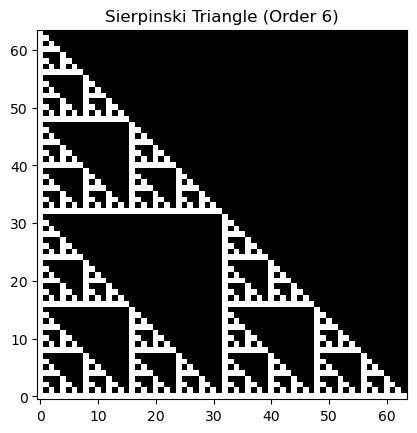

Estimated Fractal Dimension of the Sierpinski Triangle: 1.573
Absolute Error 0.012108917389895169
Relative Error [%] 0.7639876264823694


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def sierpinski_triangle(n):
    """Generate a Sierpinski Triangle of order n in a 2D binary array."""
    size = 2 ** n
    triangle = np.zeros((size, size), dtype=int)

    # Function to fill in the Sierpinski Triangle pattern
    def fill_triangle(x, y, size):
        if size == 1:
            triangle[x, y] = 1
        else:
            new_size = size // 2
            fill_triangle(x, y, new_size)
            fill_triangle(x + new_size, y, new_size)
            fill_triangle(x, y + new_size, new_size)

    fill_triangle(0, 0, size)
    return triangle

def box_counting_fractal_dimension(mask):
    """Estimate the fractal dimension of a binary mask using the box-counting method."""
    binary_image = mask.astype(int)
    
    # Define a range of box sizes (logarithmically spaced)
    min_box_size = 2  # Minimum box size (should be >= 2)
    max_box_size = min(mask.shape) // 2  # Maximum box size
    box_sizes = np.logspace(np.log2(min_box_size), np.log2(max_box_size), num=10, base=2, dtype=int)

    counts = []
    for size in box_sizes:
        count = 0
        for x in range(0, mask.shape[0], size):
            for y in range(0, mask.shape[1], size):
                if np.any(binary_image[x:x+size, y:y+size]):
                    count += 1
        counts.append(count)
    
    # Perform a linear fit on the log-log plot
    log_box_sizes = np.log(np.array(box_sizes))
    log_counts = np.log(counts)
    coeffs = np.polyfit(log_box_sizes, log_counts, 1)
    fractal_dimension = -coeffs[0]

    # Plot the log-log relationship
    """
    plt.figure(figsize=(8, 6))
    plt.plot(log_box_sizes, log_counts, 'o-', label="Box-Counting Data")
    plt.plot(log_box_sizes, np.polyval(coeffs, log_box_sizes), 'r--', label=f"Fit Line (Slope = {fractal_dimension:.2f})")
    plt.xlabel("log(1 / Box Size)")
    plt.ylabel("log(Number of Boxes)")
    plt.title("Fractal Dimension Estimate for Sierpinski Triangle (circa 1.585)")
    plt.legend()
    plt.show()
    """

    return fractal_dimension

sierpinski = sierpinski_triangle(6)
plt.imshow(sierpinski, cmap='gray', origin='lower')
plt.title("Sierpinski Triangle (Order 6)")
plt.show()

# Estimate the fractal dimension of the Sierpinski Triangle
true_value = np.log(3)/np.log(2)
fractal_dim = box_counting_fractal_dimension(sierpinski)
print(f"Estimated Fractal Dimension of the Sierpinski Triangle: {fractal_dim:.3f}")
print("Absolute Error", true_value-fractal_dim)
print("Relative Error [%]", 100*np.abs((true_value-fractal_dim)/true_value))

1.6379765716472998
1.6111495254992487
1.590969631199192
1.560984724177797
1.529266396851855
1.4910148858432268
1.4544424692751137
1.4053903854013965
1.3661161526183296
1.3331558149447824
1.2838663481322654
1.2421684737211252
1.207087913691072
1.1566145666699763
1.1077839143520767
1.038685415136028
0.9692777093206096
0.9167152848756394
0.8528533728543373
0.8001375929043137


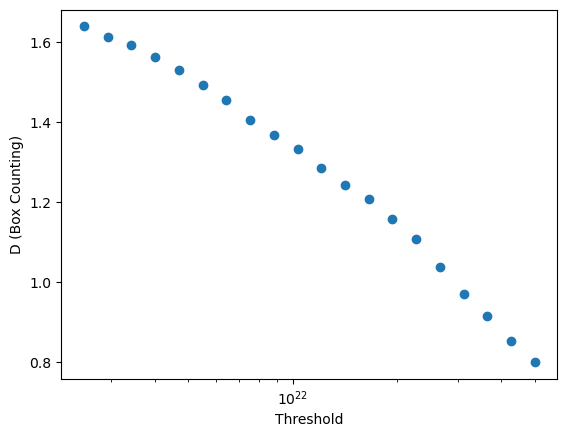

In [3]:
thresholds = np.logspace(np.log10(2.5e21), np.log10(5e22), 20)

fractal_dimensions = []
for threshold in thresholds:
    mask = N_H2_OA >= threshold

    fractal_dim = box_counting_fractal_dimension(mask)
    print(fractal_dim)
    fractal_dimensions.append(fractal_dim)

plt.scatter(thresholds, fractal_dimensions)
plt.xlabel('Threshold')
plt.ylabel('D (Box Counting)')

plt.xscale("log")

  0%|          | 0/10 [00:00<?, ?it/s]

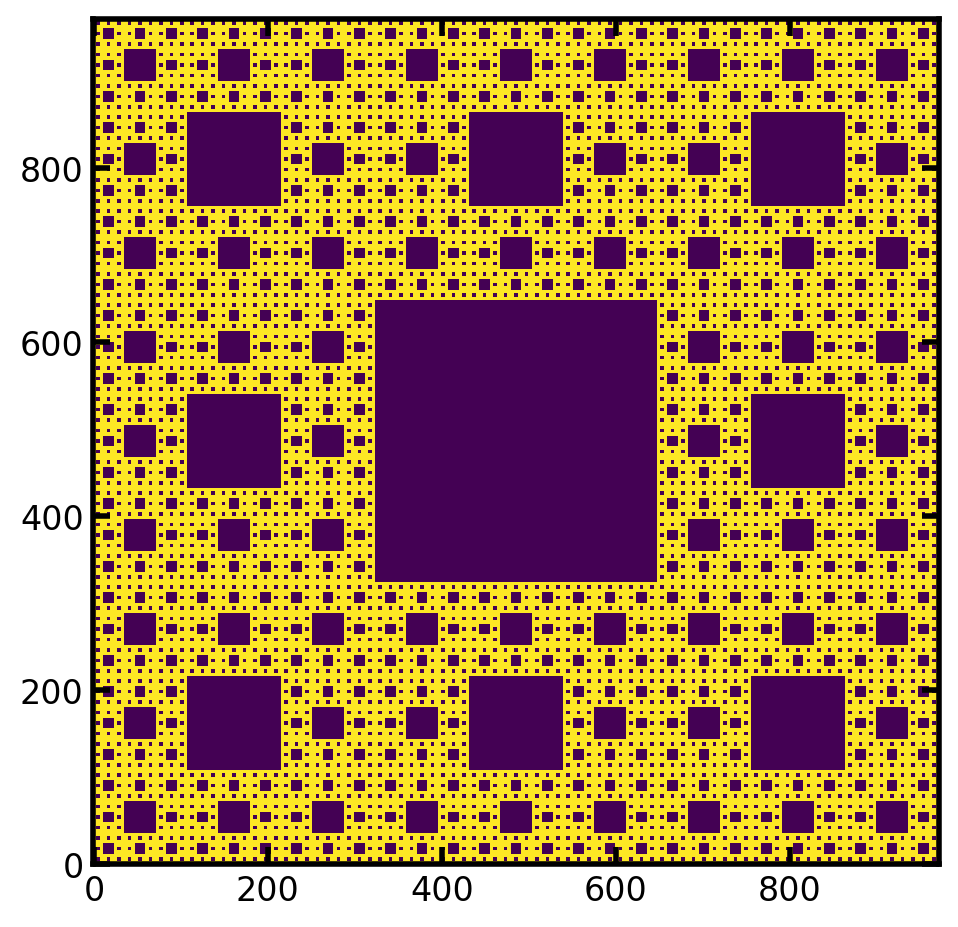

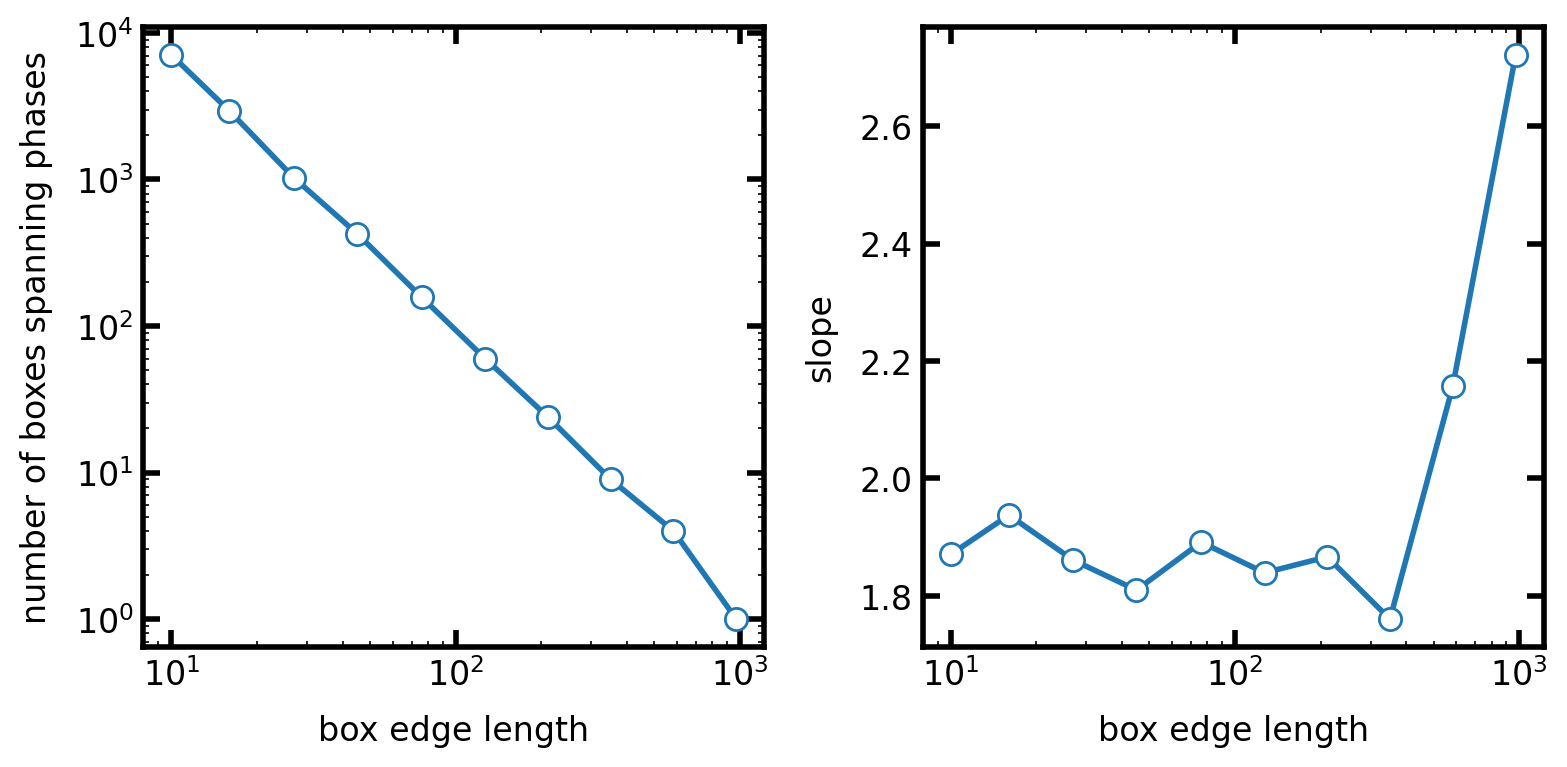

In [ ]:
import matplotlib.pyplot as plt
import porespy as ps
ps.visualization.set_mpl_style()

im = ps.generators.sierpinski_foam(4, 5)
plt.imshow(im)

data = ps.metrics.boxcount(im)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('box edge length')
ax1.set_ylabel('number of boxes spanning phases')
ax2.set_xlabel('box edge length')
ax2.set_ylabel('slope')
ax2.set_xscale('log')
ax1.plot(data.size, data.count,'-o')
ax2.plot(data.size, data.slope,'-o')

coeffs = np.polyfit(data.size, data.count, 1)
fractal_dimension = -coeffs[0]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

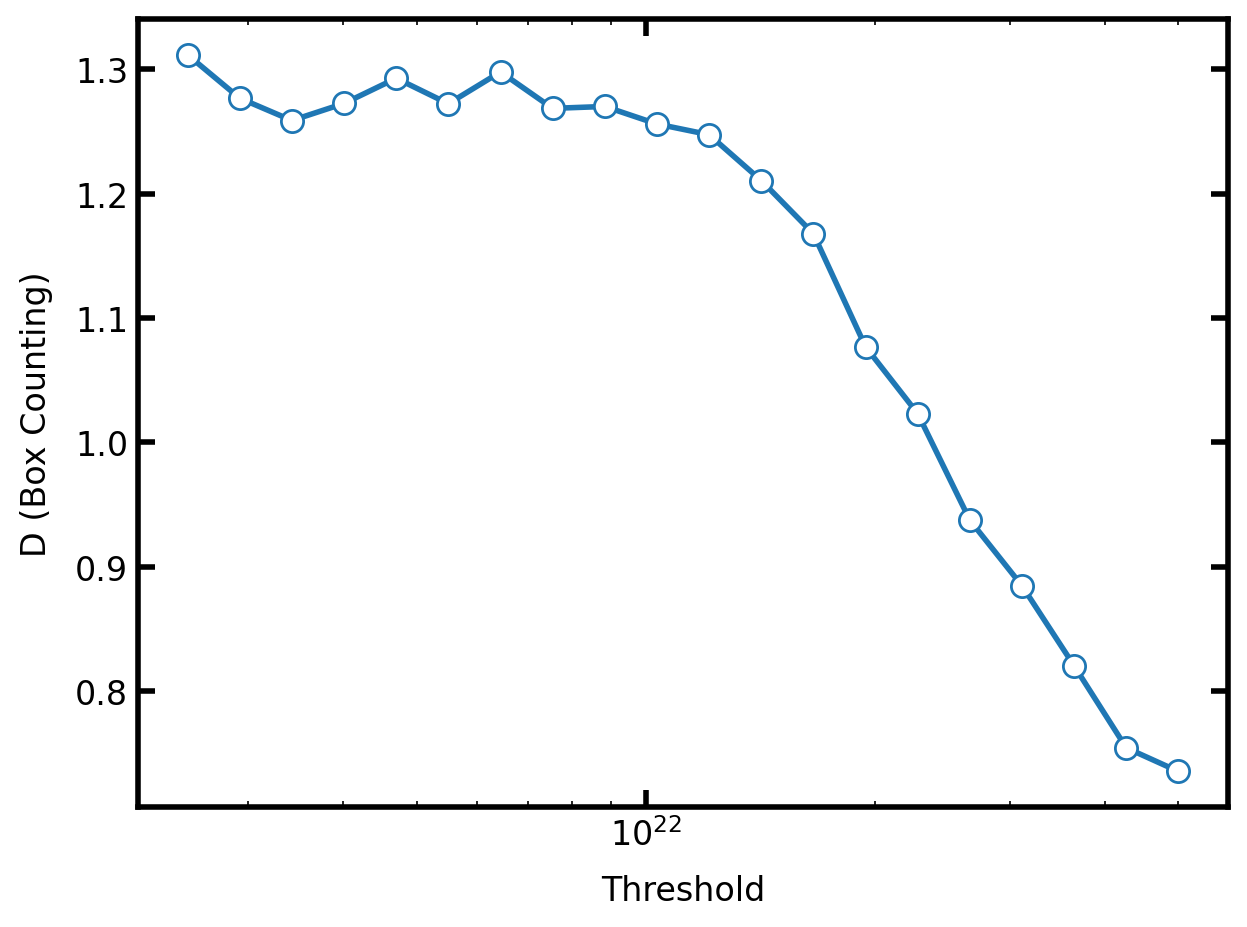

In [60]:
thresholds = np.logspace(np.log10(2.5e21), np.log10(5e22), 20)

fractal_dimensions = []
for threshold in thresholds:
    im = N_H2_OA >= threshold
    data = ps.metrics.boxcount(im)
    
    fractal_dimensions.append(np.mean(data.slope[:6]))

plt.plot(thresholds, fractal_dimensions, '-o')
plt.xlabel('Threshold')
plt.ylabel('D (Box Counting)')

plt.xscale("log")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

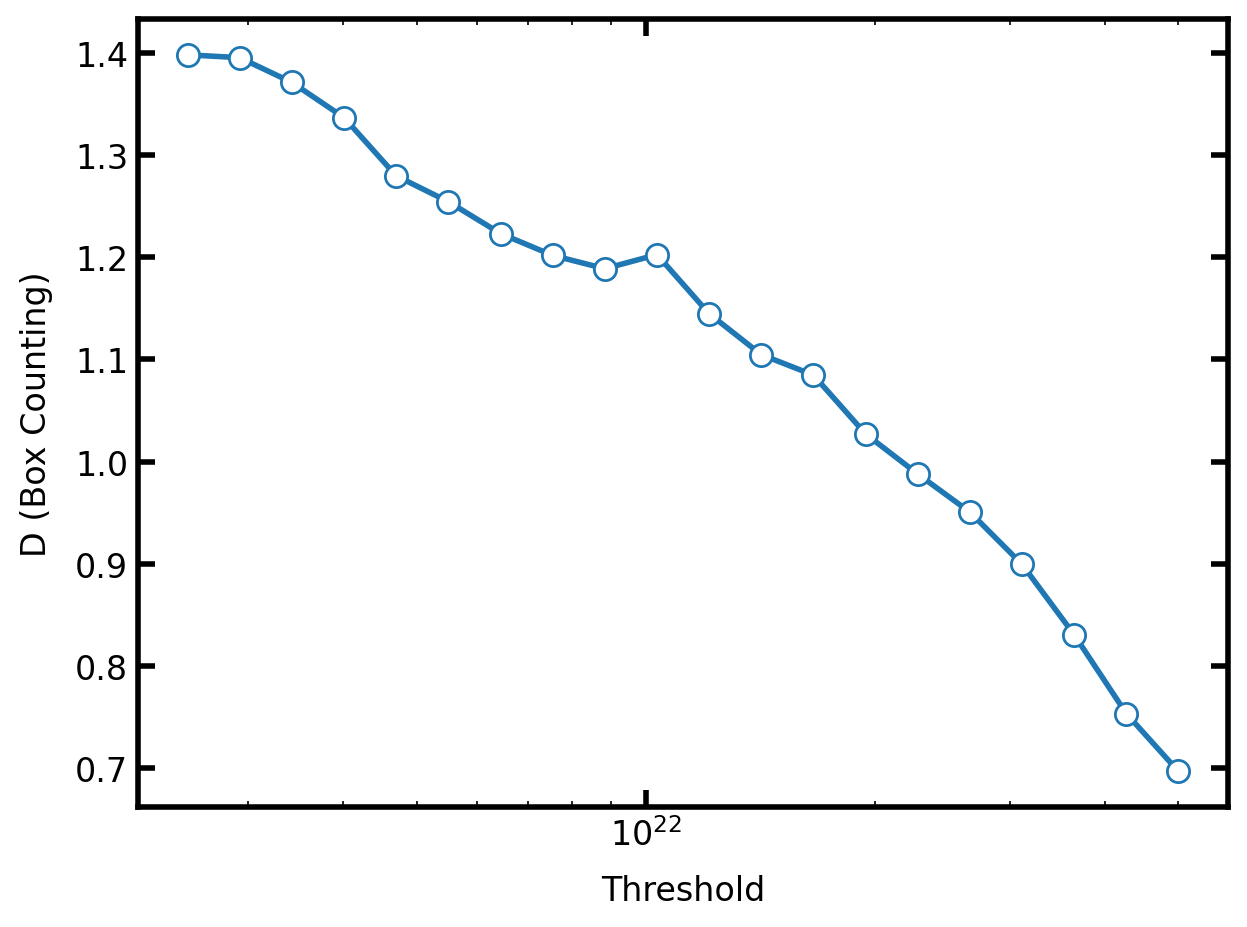

In [59]:
thresholds = np.logspace(np.log10(2.5e21), np.log10(5e22), 20)

fractal_dimensions = []
for threshold in thresholds:
    im = N_H2_OB >= threshold
    data = ps.metrics.boxcount(im)
    
    fractal_dimensions.append(np.mean(data.slope[:6]))

plt.plot(thresholds, fractal_dimensions, '-o')
plt.xlabel('Threshold')
plt.ylabel('D (Box Counting)')

plt.xscale("log")